# Explore RNAseq of zebrafish photoreceptors 
### [Transcription factors underlying photoreceptor diversity, Angueyra et al. eLife 2023;12:e81579](https://doi.org/10.7554/eLife.81579)

This notebook can be accessed here:  
[angueyraLab.github.io/drRNAseq/lab](angueyra.github.io/drRNAseq/lab)  

## Follow instructions below to explore dataset openly available at: https://github.com/angueyraLab/drRNAseq.  
AND  
## Make comparisons with published RNAseq datasets containing zebrafish adult photoreceptors, including:  
- [Ogawa and Corbo (2021)](https://doi.org/10.1038/s41598-021-96837-z): FACS + 10x from adult rods, cones and bipolar cells  
- [Hoang _et al._ (2020)](https://doi.org/10.1126/science.abb8598): 10x from whole retina (extracted data from adult photoreceptors and reclustered)  
- [Sun, Galicia and Stenkamp (2018)](https://doi.org/10.1186/s12864-018-4499-y): FACS + bulk RNAseq from adult rods (GFP+) and other retinal cells (GFP-)  
----
----

### How to use the notebook
- To explore the datasets, you will need to run the code in the cells below.  
- To run a cell, you need to click unto it to select it and press "Ctrl"+"Enter" or the small *play* symbol in the navigation bar on top of this notebook.  
- Cells that are currently running display [\*] on the left.  
- Cells that have finished running will display a number instead (e.g.[8])
---
---
#### Saving plots:
- Right click on the image and click on "Create New View for Output"
- Right click on image in Output View panel and click on "Save As..."

#### First: load python environment

In [1]:
import pyodide_kernel
print("Successfully loaded pyolite version {0}".format(pyodide_kernel.__version__))

%pip install -q ipywidgets

Successfully loaded pyolite version 0.1.0b4


#### Second: load all necessary extensions (this may take a few minutes...)

In [2]:
print("Loading extensions...")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import zscore
import os
import pyodide
import piplite

import ipywidgets
pBGMenu = ipywidgets.Dropdown(options=['Light', 'Dark'],value='Dark',disabled=False, layout=ipywidgets.Layout(width='20%', height='40px'))
pBGLabel = ipywidgets.widgets.Label('Select plotting style', layout=ipywidgets.Layout(width='20%', height='30px'))
pBG = ipywidgets.widgets.VBox([pBGLabel,pBGMenu])
heatmapNorm = ipywidgets.Checkbox(value=False, description='Heatmap normalization', disabled=False)

# Load plotting function
URL = 'https://raw.githubusercontent.com/angueyraLab/drRNAseq/main/content/juanPlot-0a3-py2.py3-none-any.whl'
await piplite.install(URL)
from juanPlot import *
print("Successfully loaded extensions!")


# load datasets
print("Loading datasets...")
gf = pd.read_csv('./data/Angueyra2021_Photoreceptors.csv')
print("\t Angueyra et al. (2022)")

zfO = pd.read_csv('./data/Ogawa2021_10x_photoreceptors.csv')
print("\t Ogawa and Corbo (2021)")

zfH = pd.read_csv('./data/Hoang2020_10x_photoreceptors.csv')
print("\t Hoang et al. (2020)")

zfS = pd.read_csv('./data/Sun2018_FACS_Rods.csv')
print("\t Sun, Galicia, Stenkamp (2018)")

print("Successfully loaded datasets!\n\n")

# Display selector for plotting background:
pBG

Loading extensions...


/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Successfully loaded extensions!
Loading datasets...
	 Angueyra et al. (2021)
	 Ogawa and Corbo (2021)
	 Hoang et al. (2020)
	 Sun, Galicia, Stenkamp (2018)
Successfully loaded datasets!




#### Define some plotting bases and colors

In [3]:
# photoreceptor Colors
pC = {
    'r' : '#747474', # Rods
    'u' : '#B540B7', # UV cones
    's' : '#4669F2', # S cones
    'm' : '#04CD22', # M cones
    'l' : '#CC2C2A', # L cones
    'm4': '#cdcd04', # opn1mws4-expressing M cones
    'onBC': '#ccf2ff', # on bipolar cells
    'offBC': '#663d00', # off bipolar cells
    'plt' : '',
    'zfO': '',
}

# default parameters for plotting
if pBGMenu.value=='Dark':
    # dark background
    plt.style.use('dark_background')
    params = {"ytick.color" : "w", "xtick.color" : "w",
              "axes.labelcolor" : "w", "axes.edgecolor" : "w",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3, "ytick.major.width" : 3,
             "xtick.major.size" : 8, "ytick.major.size" : 8,
             "text.color" : "w"}
    plt.rcParams.update(params)
    baseColor = '#ffffff' #white
else:
    # white background
    plt.style.use('default')
    params = {"ytick.color" : "k", "xtick.color" : "k",
              "axes.labelcolor" : "k", "axes.edgecolor" : "k",
             "axes.linewidth" : 3,
             "xtick.major.width" : 3, "ytick.major.width" : 3,
             "xtick.major.size" : 8, "ytick.major.size" : 8,
             "text.color" : "k"}
    plt.rcParams.update(params)
    baseColor = '#000000' #black
    


print("Plotting style is: {0}".format(pBGMenu.value))

Plotting style is: Dark


***
# Index <a id='Index'></a>
- [Bar plot for single gene: Angueyra et al. (2022)](#barPlot)
- [heatMap for gene family: Angueyra et al. (2021)](#heatMap)
- [heatMap for gene list: Angueyra et al. (2021)](#heatMapList)
- [Bar plot for single gene: across studies](#barPlot_otherStudies)
- [heatMap for gene family: across studies](#heatMap_otherStudies)
- [heatMap for gene list: across studies](#heatMapList_otherStudies)

***
## Bar plot for single gene: provide gene symbol (e.g. '_tbx2a_')<a id='barPlot'></a>
***
[Back to Index](#Index)

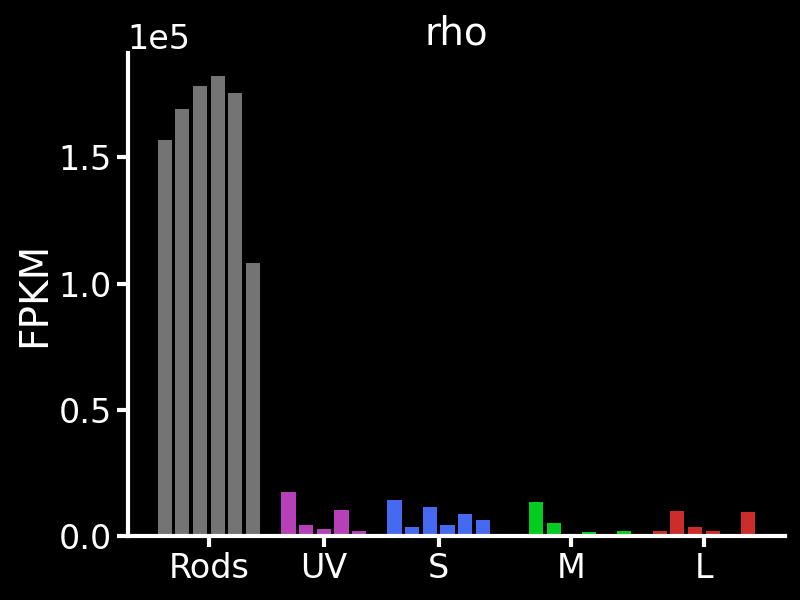

In [4]:
geneSymbol = 'rho' # replace geneSymbol here and rerun cell to replot

barData = gf[gf['symbol']==geneSymbol] #get data (should add a check here with isin)
fH, axH = plt.subplots(figsize=(8,6))
pH = plotBars(barData, geneSymbol, ax=axH, pC=pC)
plt.subplots_adjust(left=0.15, right=.95, top=0.90, bottom=0.1)
plt.tight_layout()
plt.show()

***
## HeatMap for gene family: provide gene symbol prefix (e.g. '_opn1_')<a id='heatMap'></a>
> retrieves all genes whose symbol starts with defined geneSymbol  
***

[Back to Index](#Index)

In [5]:
# display option for heatmap normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

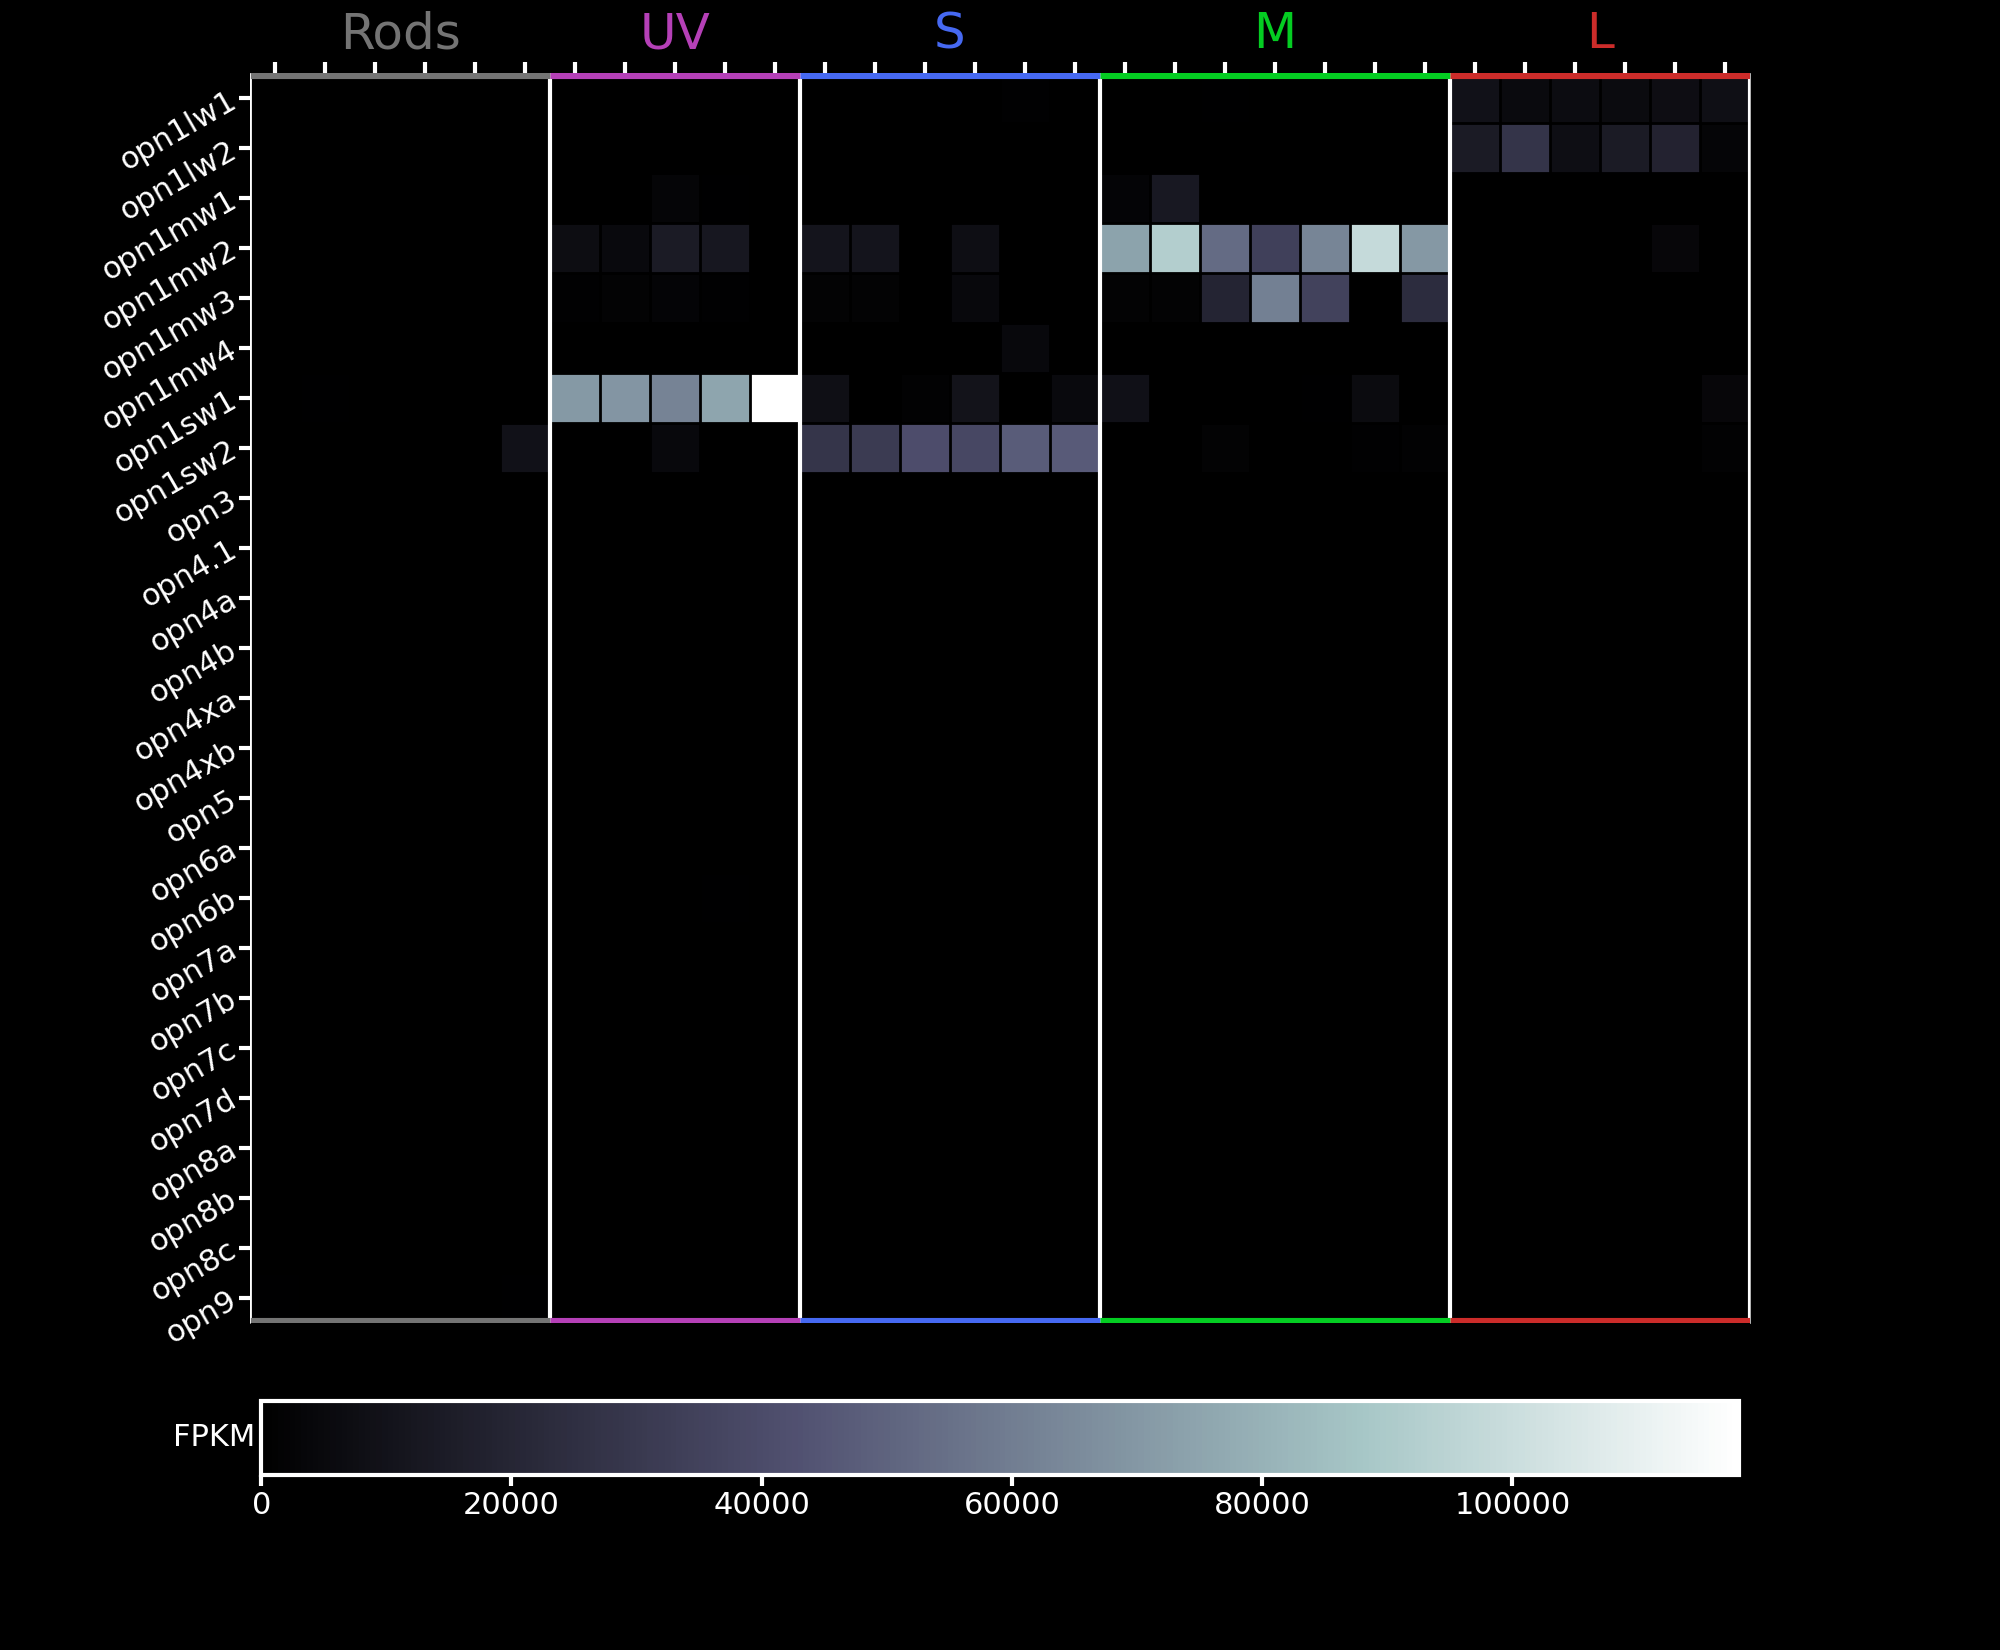

In [6]:
geneSymbol='opn' # replace geneSymbol here and rerun cell to replot

heatmapData = gf[gf['symbol'].str.startswith(geneSymbol)]
heatmapData = heatmapData.sort_values(by=["symbol"])
fH, axH = plt.subplots(figsize=(20,(0.5*heatmapData.shape[0])+4))
hmH, cbH = heatmap(heatmapData, pC = pC, norm=heatmapNorm.value)
plt.tight_layout()
plt.show()

***
## HeatMap for gene list: provide gene symbols separated by "|" (e.g. '_tbx2a_|_tbx2b_|_foxq2_')<a id='heatMapList'></a>
> retrieves all genes in list and creates heatmap  
***

[Back to Index](#Index)

In [7]:
# display option for heatmap normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

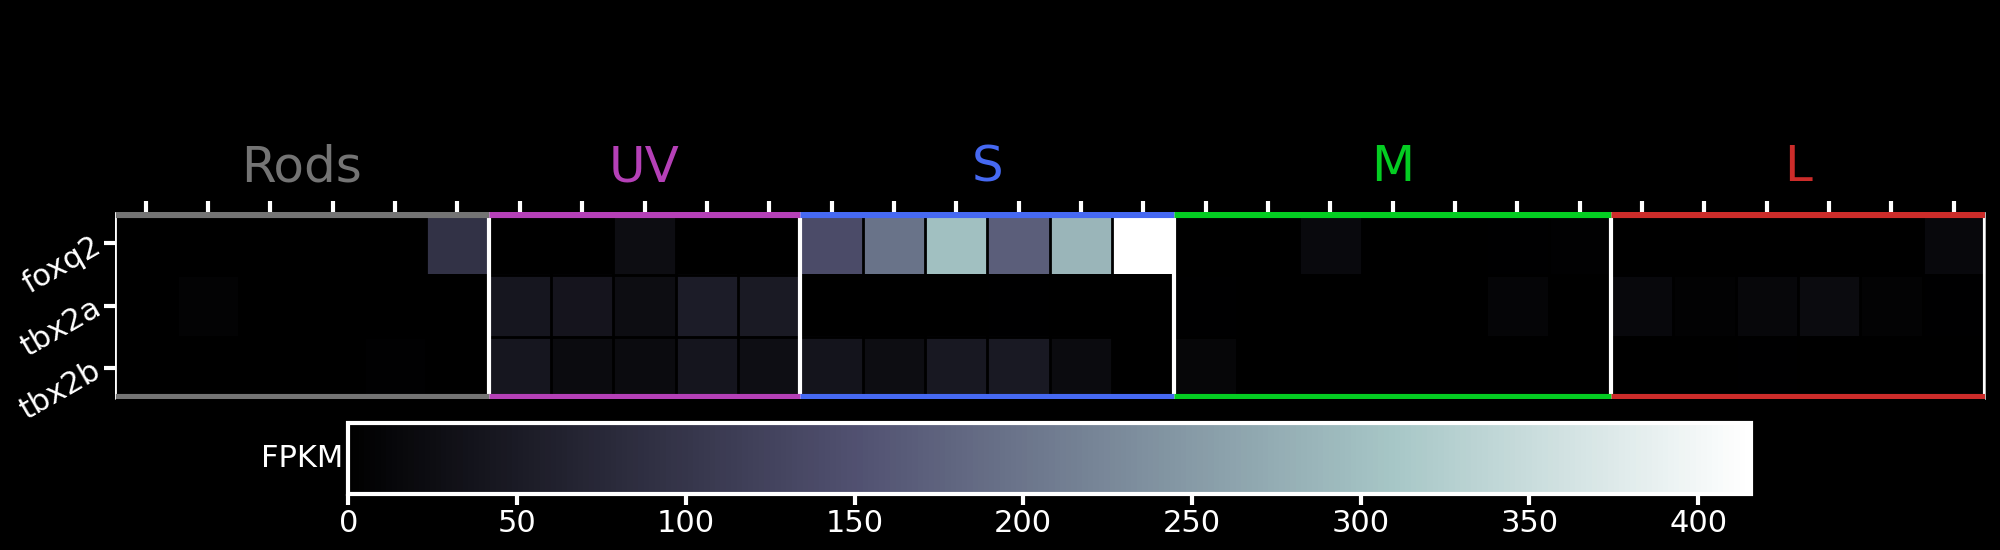

In [8]:
geneSymbol='tbx2a|tbx2b|foxq2' # replace geneSymbol here and rerun cell to replot

heatmapData = gf[gf['symbol'].str.contains(geneSymbol)]
heatmapData = heatmapData.sort_values(by=["symbol"])
fH, axH = plt.subplots(figsize=(20,(0.5*heatmapData.shape[0])+4))
hmH, cbH = heatmap(heatmapData, pC = pC, norm=heatmapNorm.value)
plt.tight_layout()
plt.show()

***
## Bar plots for single gene across studies: provide gene symbol (e.g. '_foxq2_')<a id='barPlot_otherStudies'></a>
***
[Back to Index](#Index)

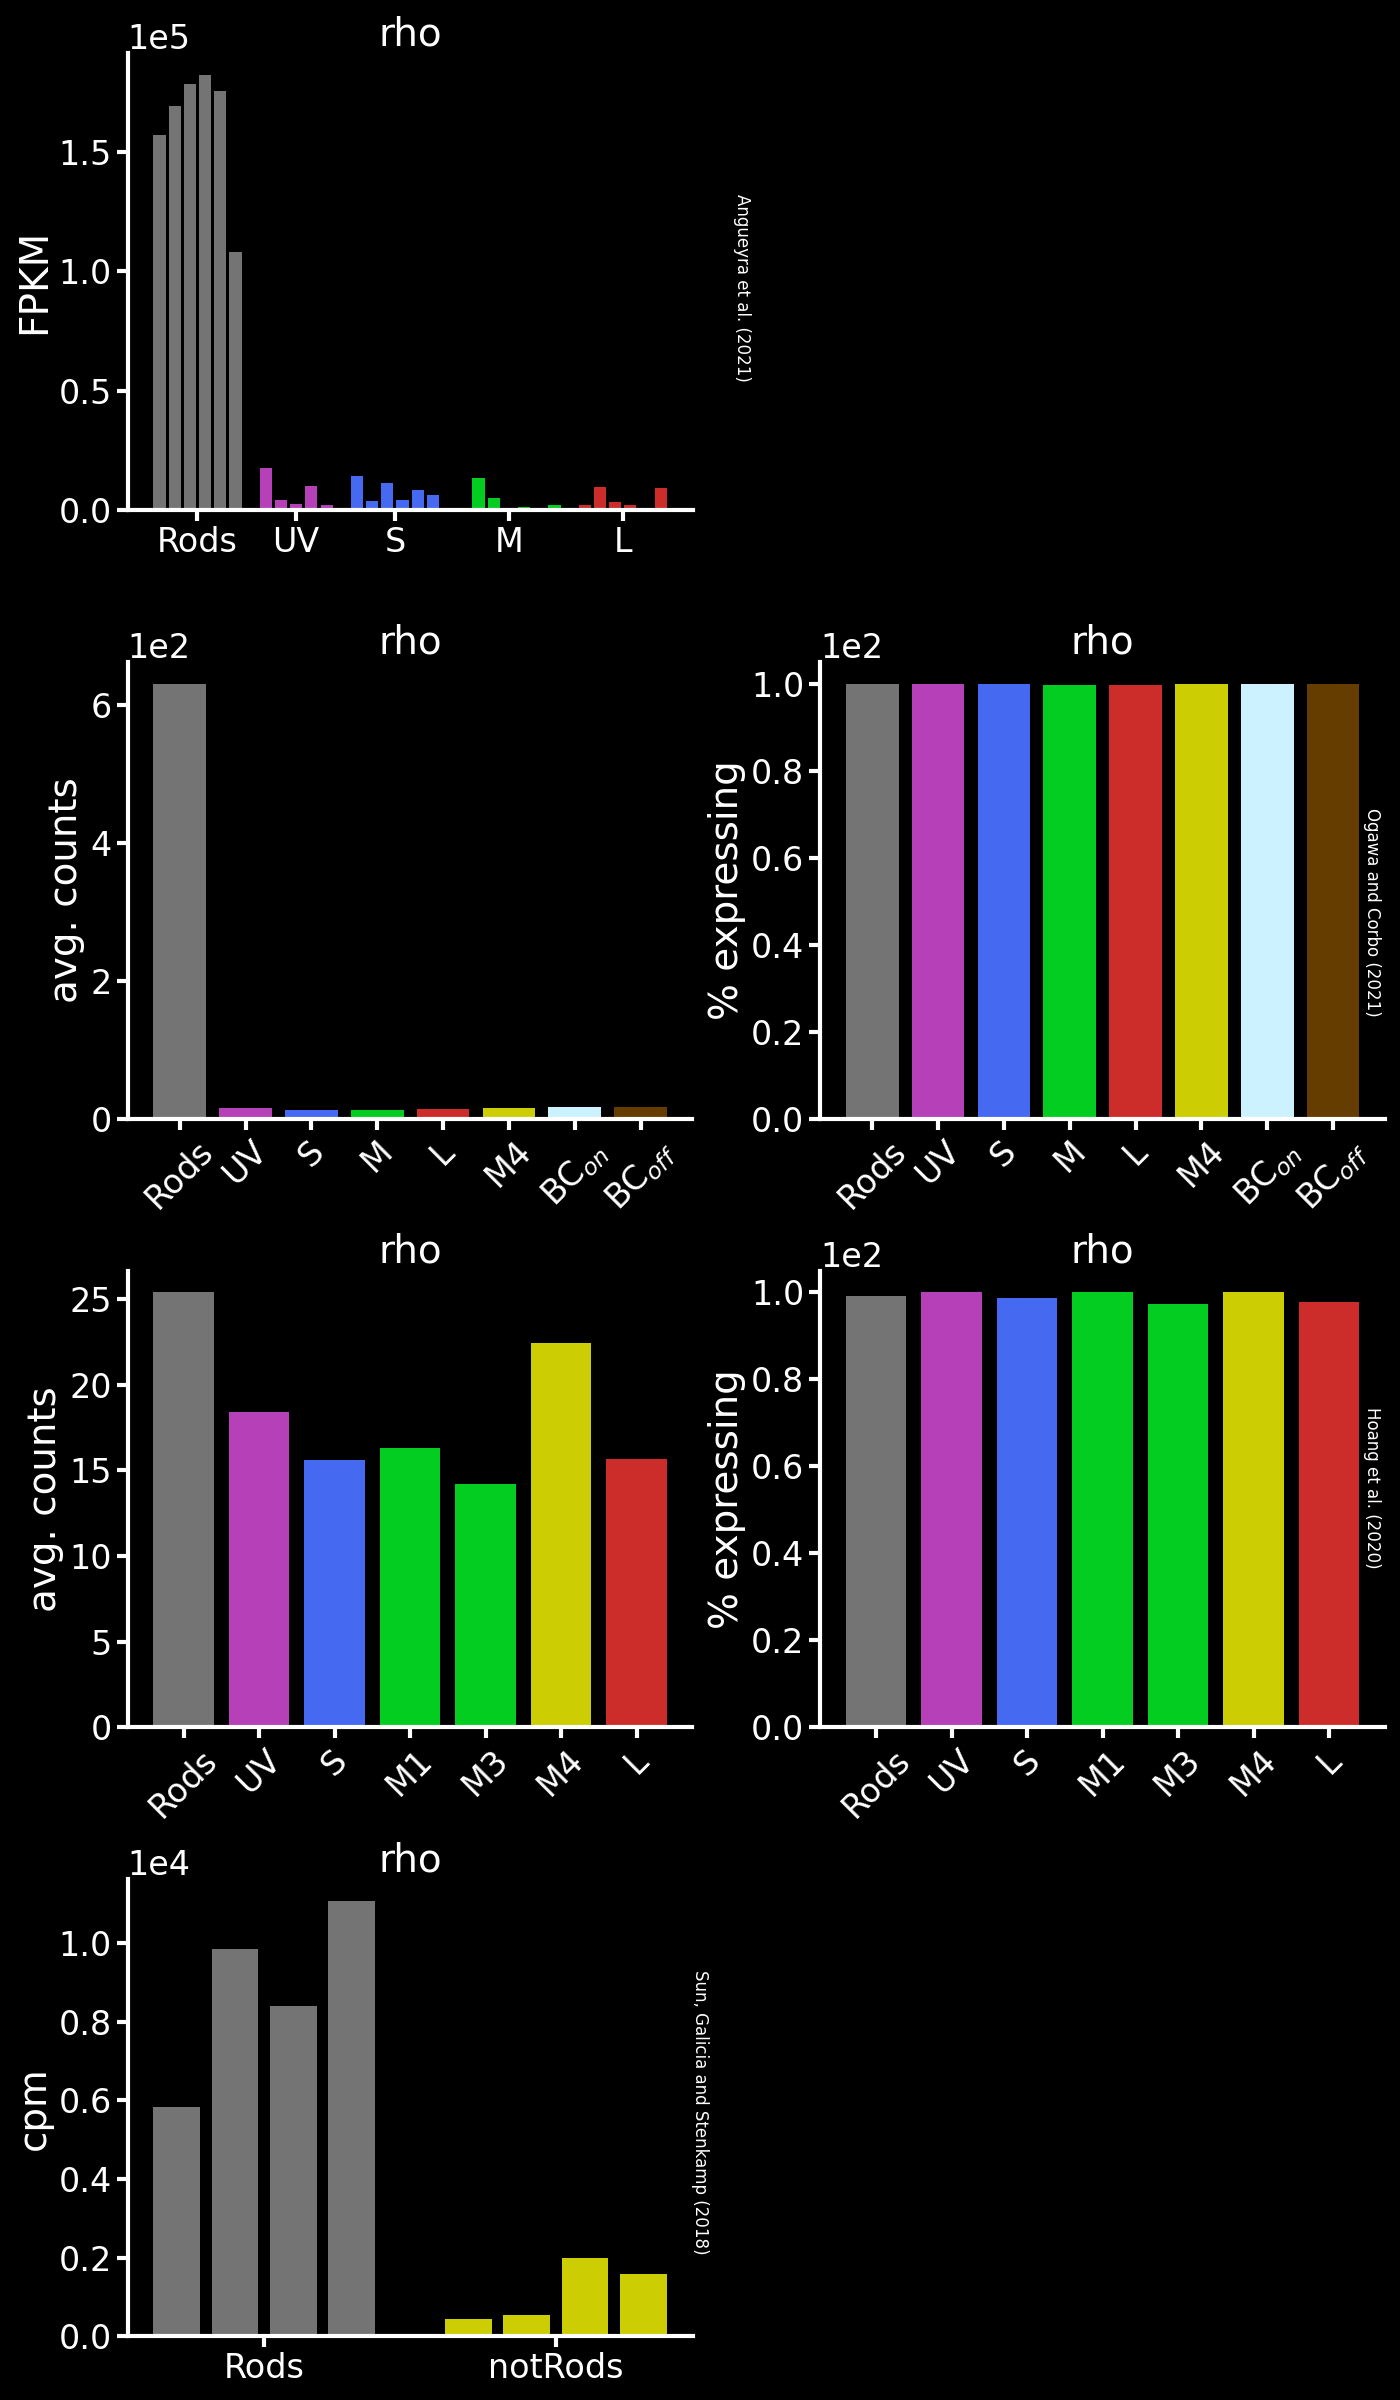

In [9]:
geneSymbol = 'rho' # replace geneSymbol here and rerun cell to replot

barData = gf[gf['symbol']==geneSymbol] # get data
barDataO = zfO[zfO['symbol']==geneSymbol] #get data
barDataH = zfH[zfH['symbol']==geneSymbol] #get data
barDataS = zfS[zfS['symbol']==geneSymbol] #get data
fH, axH = plt.subplots(4,2,figsize=(7*2,6*4))
pH0 = plotBars(barData, geneSymbol, ax=axH[0,0], pC=pC)
plt.figtext(0.53,0.88,"Angueyra et al. (2022)", va="center", ha="center", rotation= 270, size=12)
pH1 = plotBars_Ogawa2021(barDataO, geneSymbol, axH[1,0], pC, pctPlot=False)
pH2 = plotBars_Ogawa2021(barDataO, geneSymbol, axH[1,1], pC, pctPlot=True)
plt.figtext(0.98,0.62,"Ogawa and Corbo (2021)", va="center", ha="center", rotation= 270, size=12)
pH3 = plotBars_Hoang2020(barDataH, geneSymbol, axH[2,0], pC, pctPlot=False)
pH4 = plotBars_Hoang2020(barDataH, geneSymbol, axH[2,1], pC, pctPlot=True)
plt.figtext(0.98,0.38,"Hoang et al. (2020)", va="center", ha="center", rotation= 270, size=12)
pH5 = plotBars_Sun2018(barDataS, geneSymbol, axH[3,0], pC)
axH[0,1].remove()
axH[3,1].remove()
plt.figtext(0.50,0.12,"Sun, Galicia and Stenkamp (2018)", va="center", ha="center", rotation= 270, size=12)
plt.tight_layout()
plt.show()

***
## HeatMap for gene family across studies: provide gene symbol prefix (e.g. '_tbx_')<a id='heatMap_otherStudies'></a>
> retrieves all genes whose symbol starts with defined geneSymbol  
***

[Back to Index](#Index)

In [10]:
# display option for normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

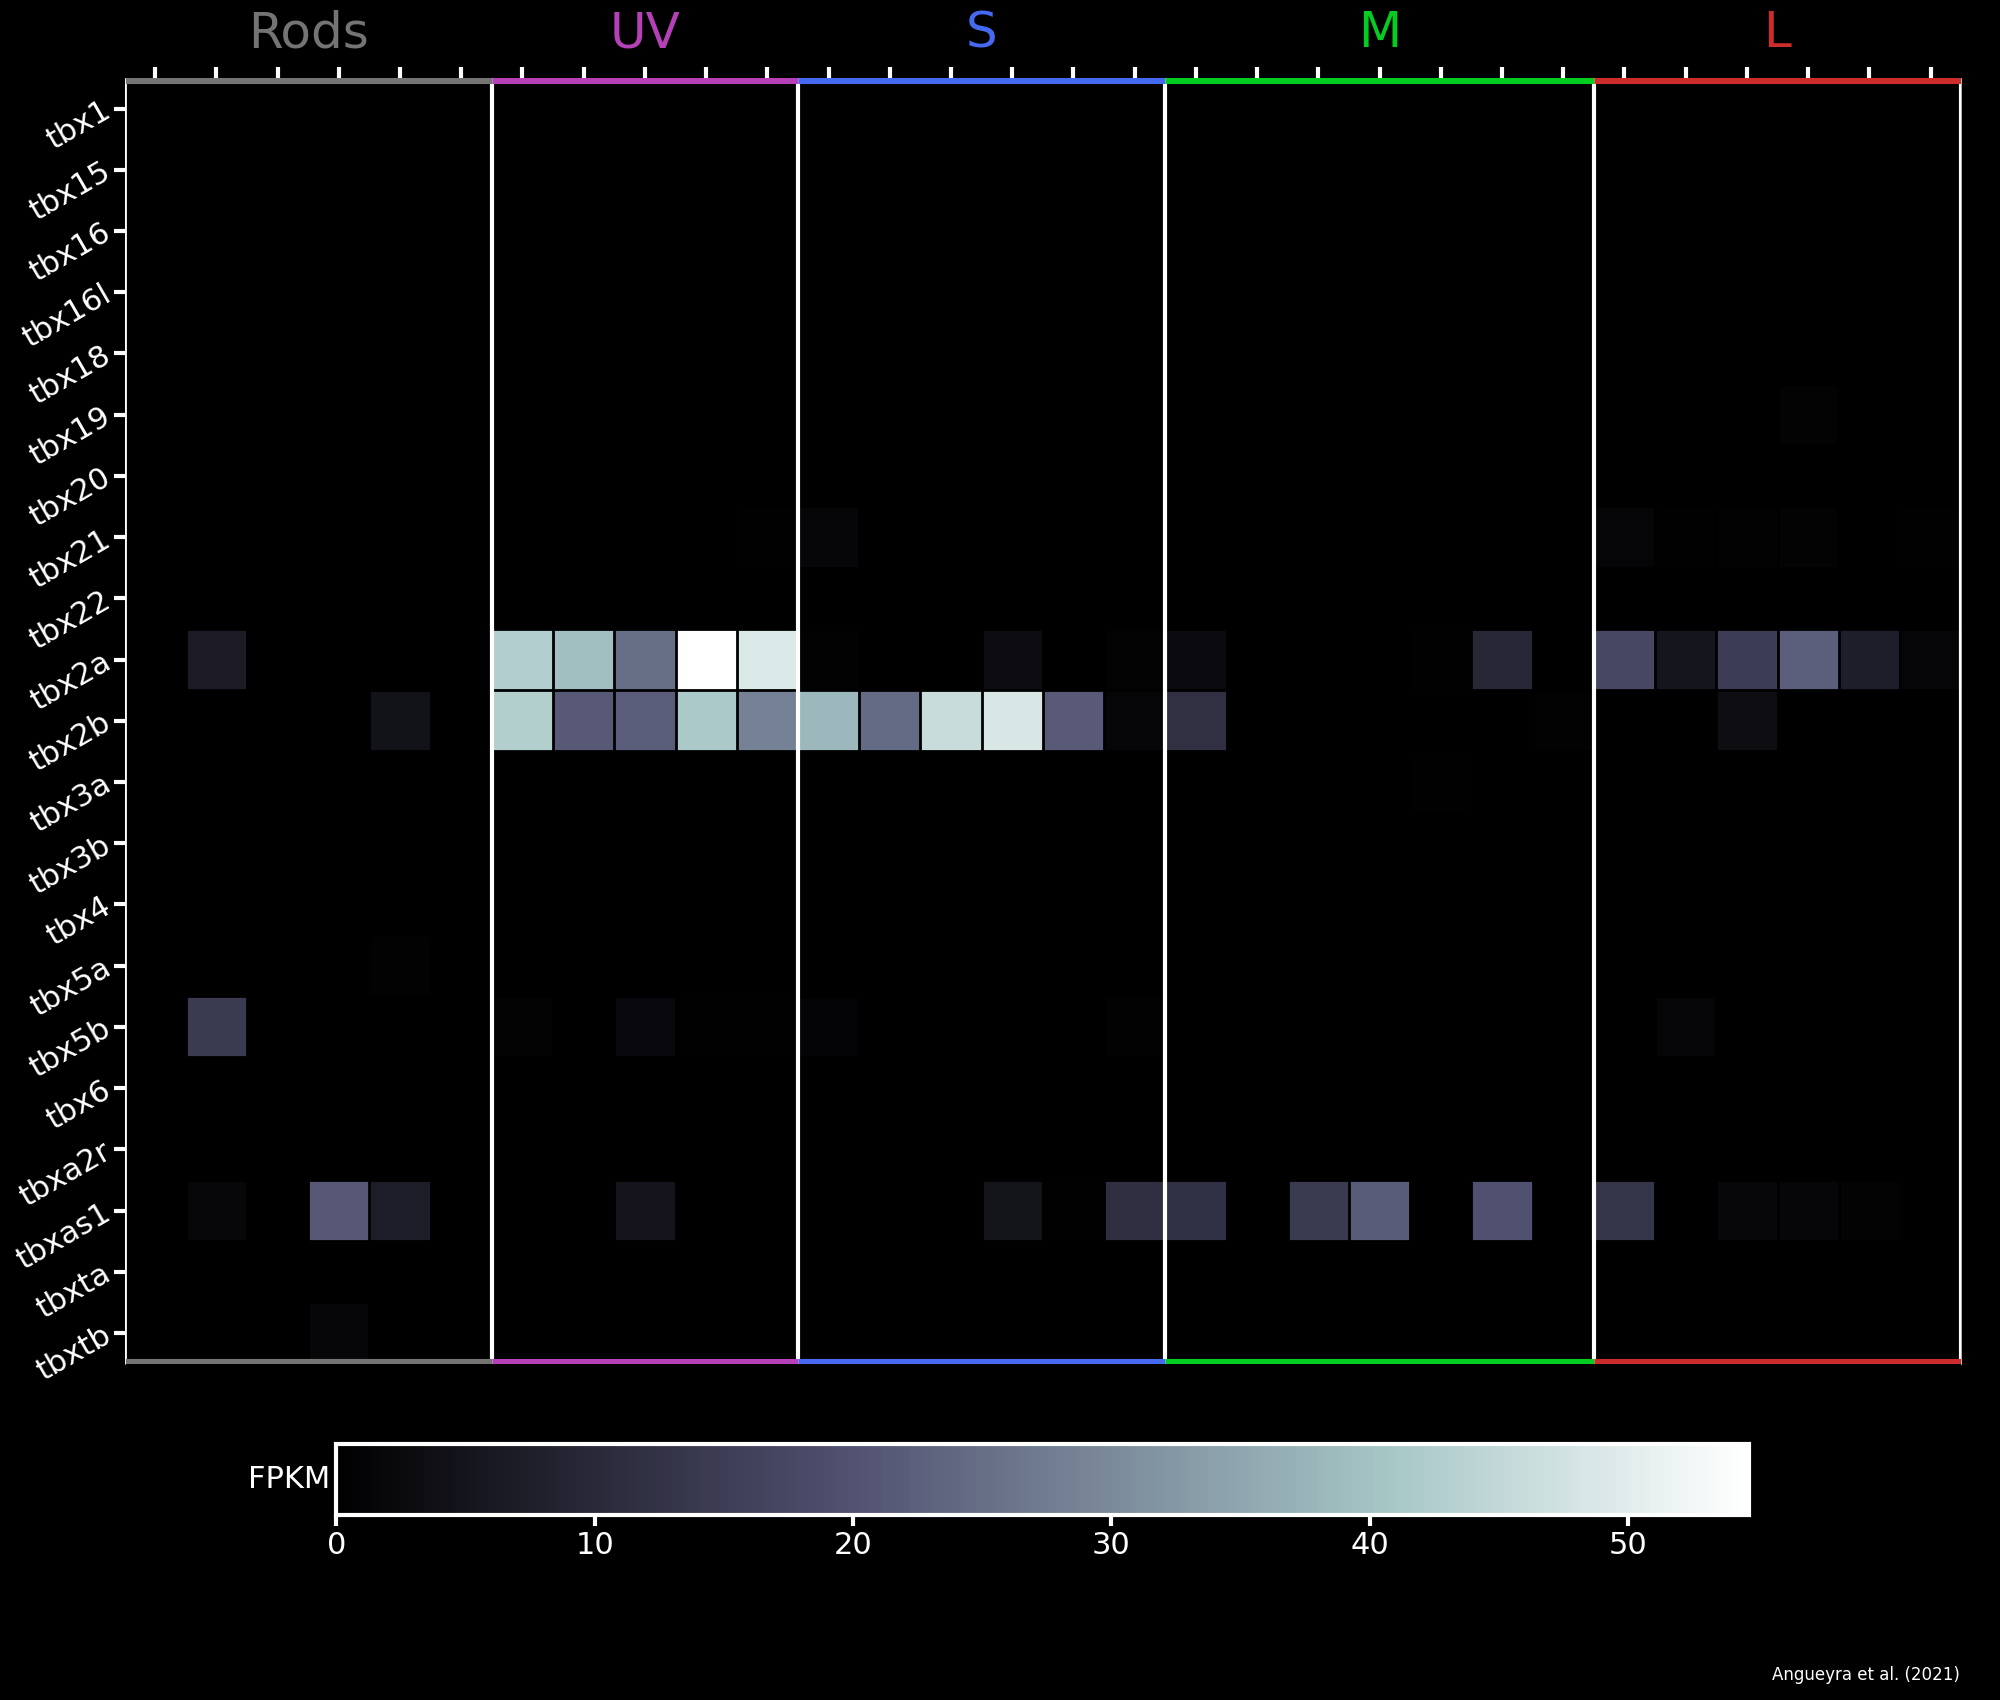

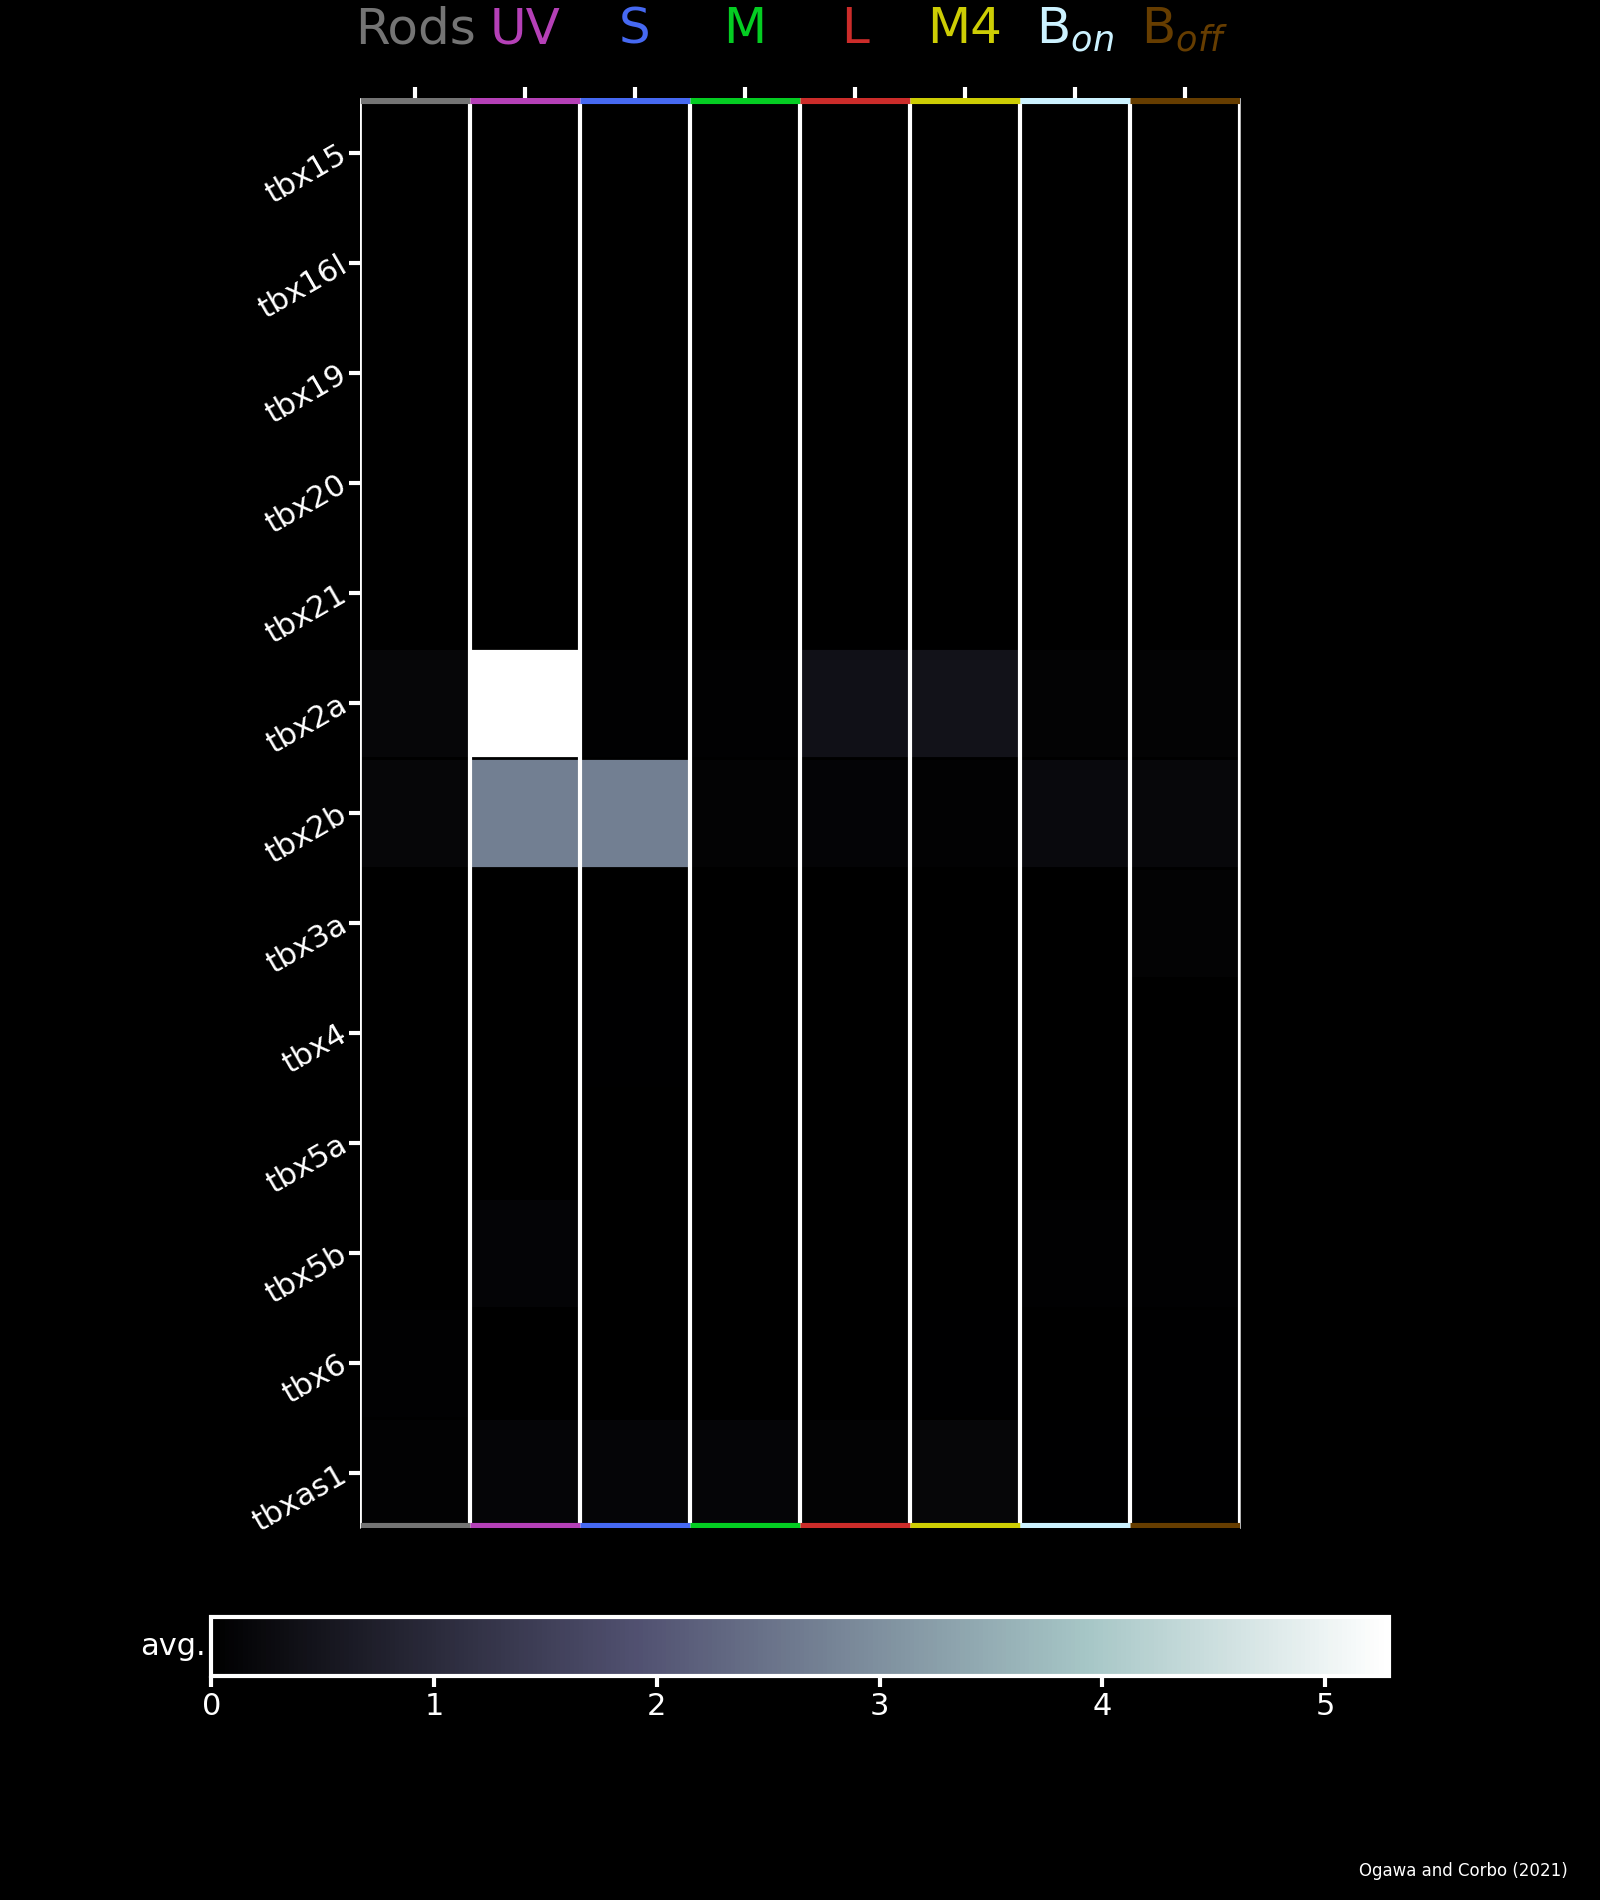

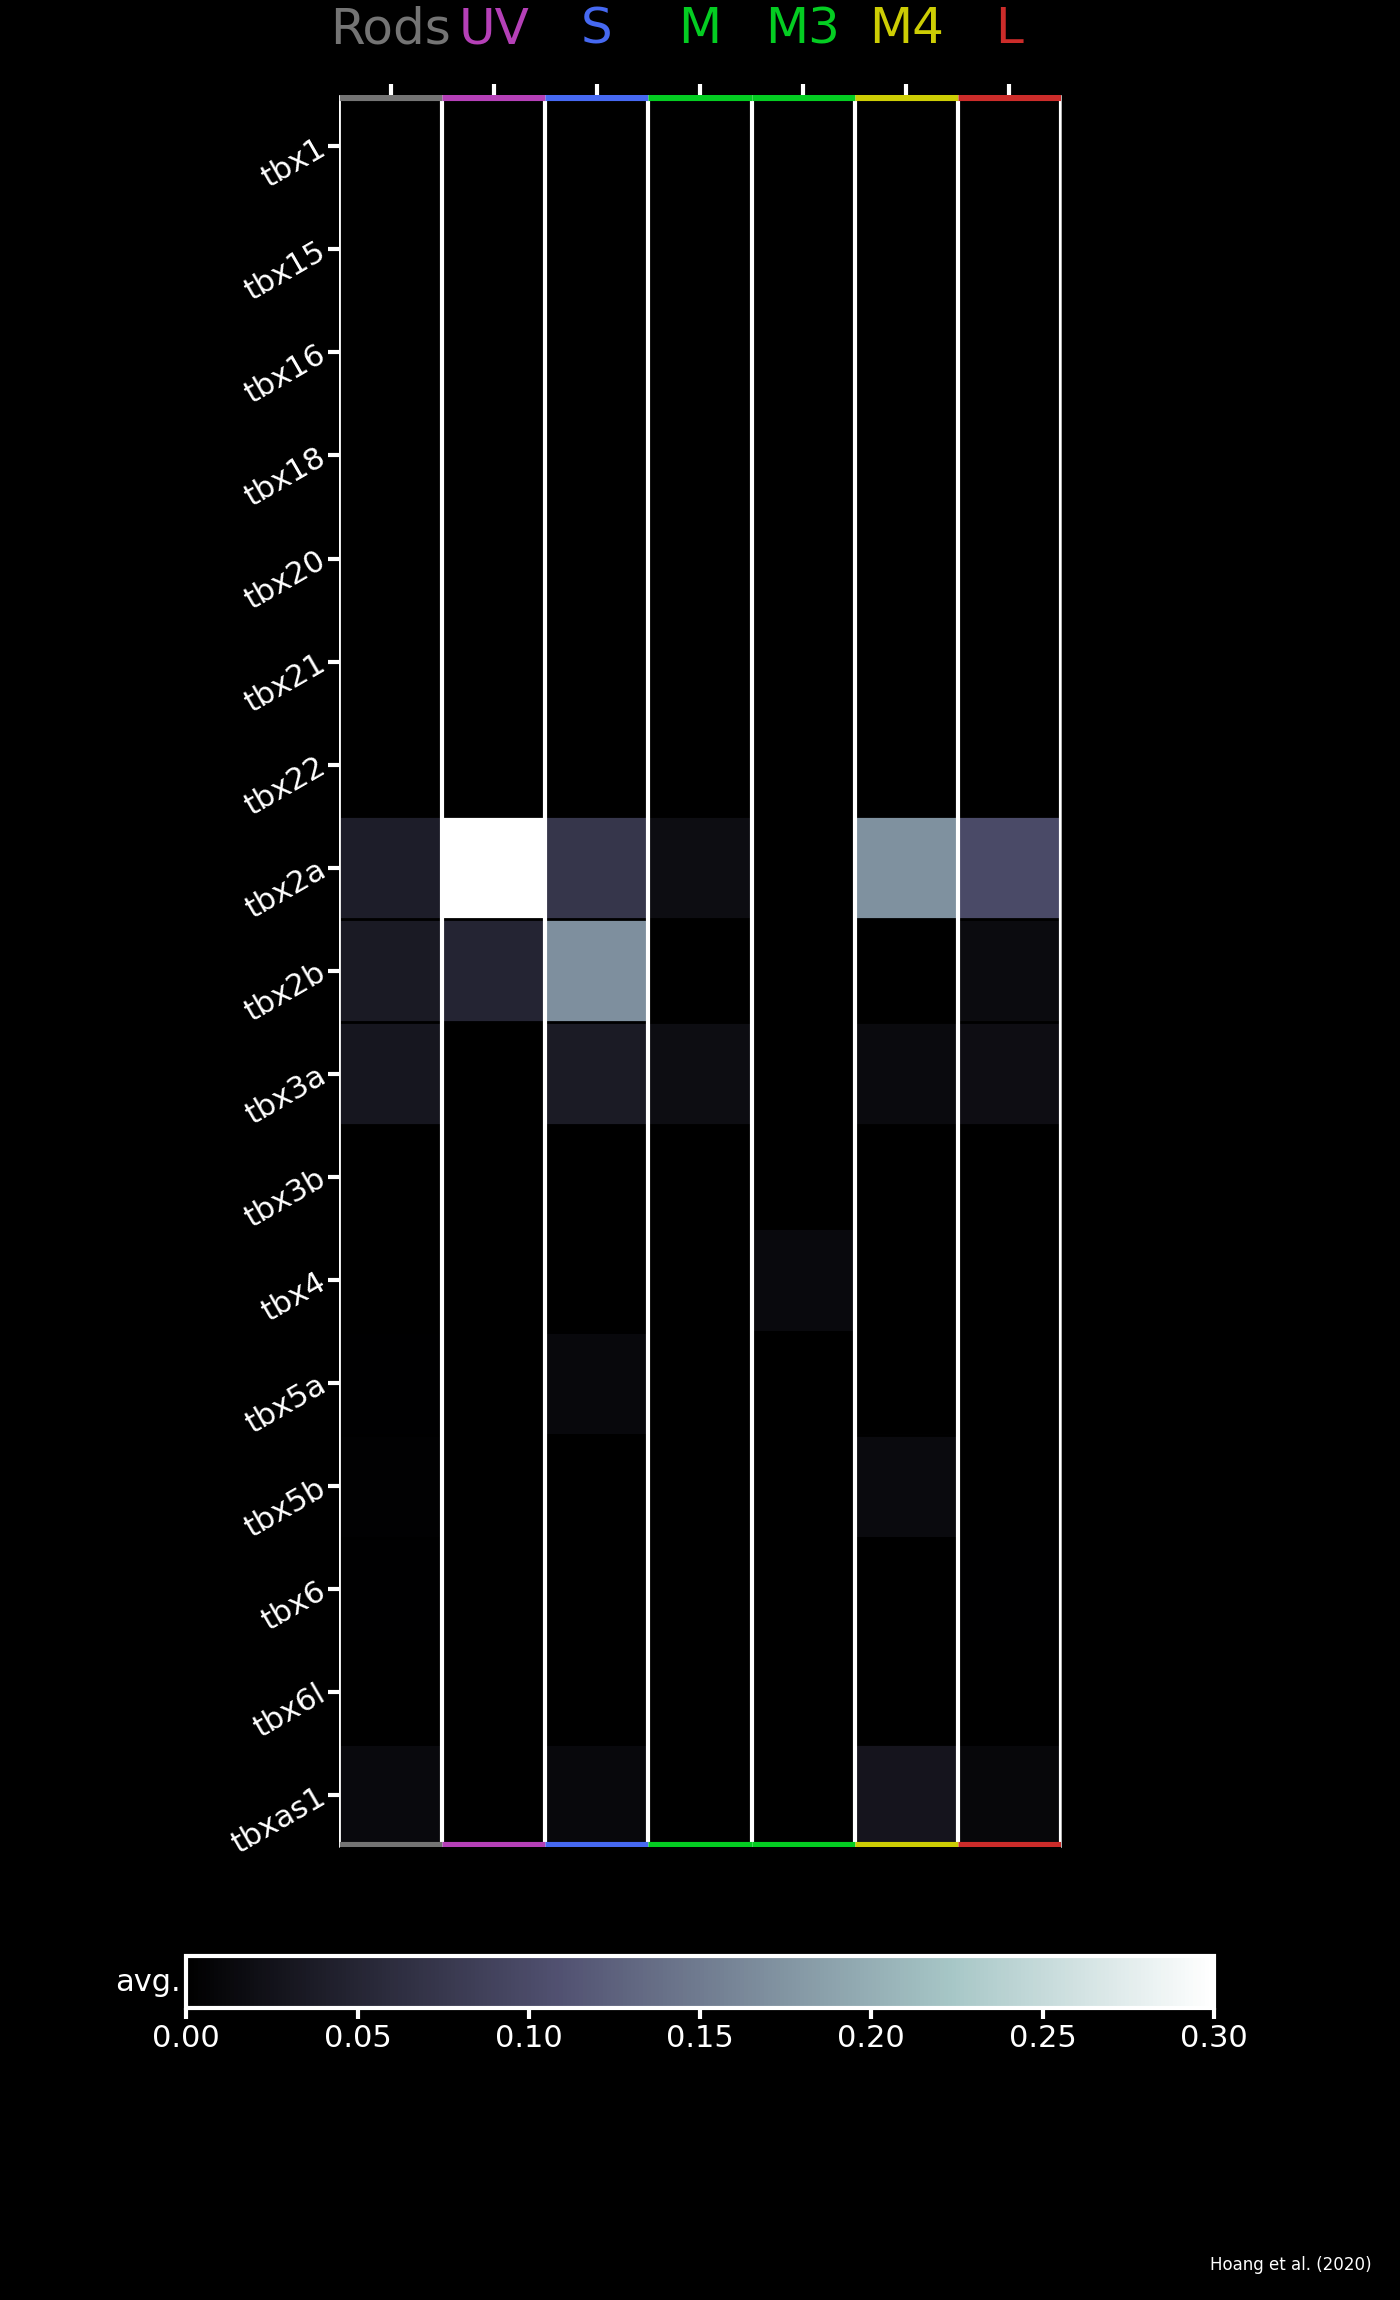

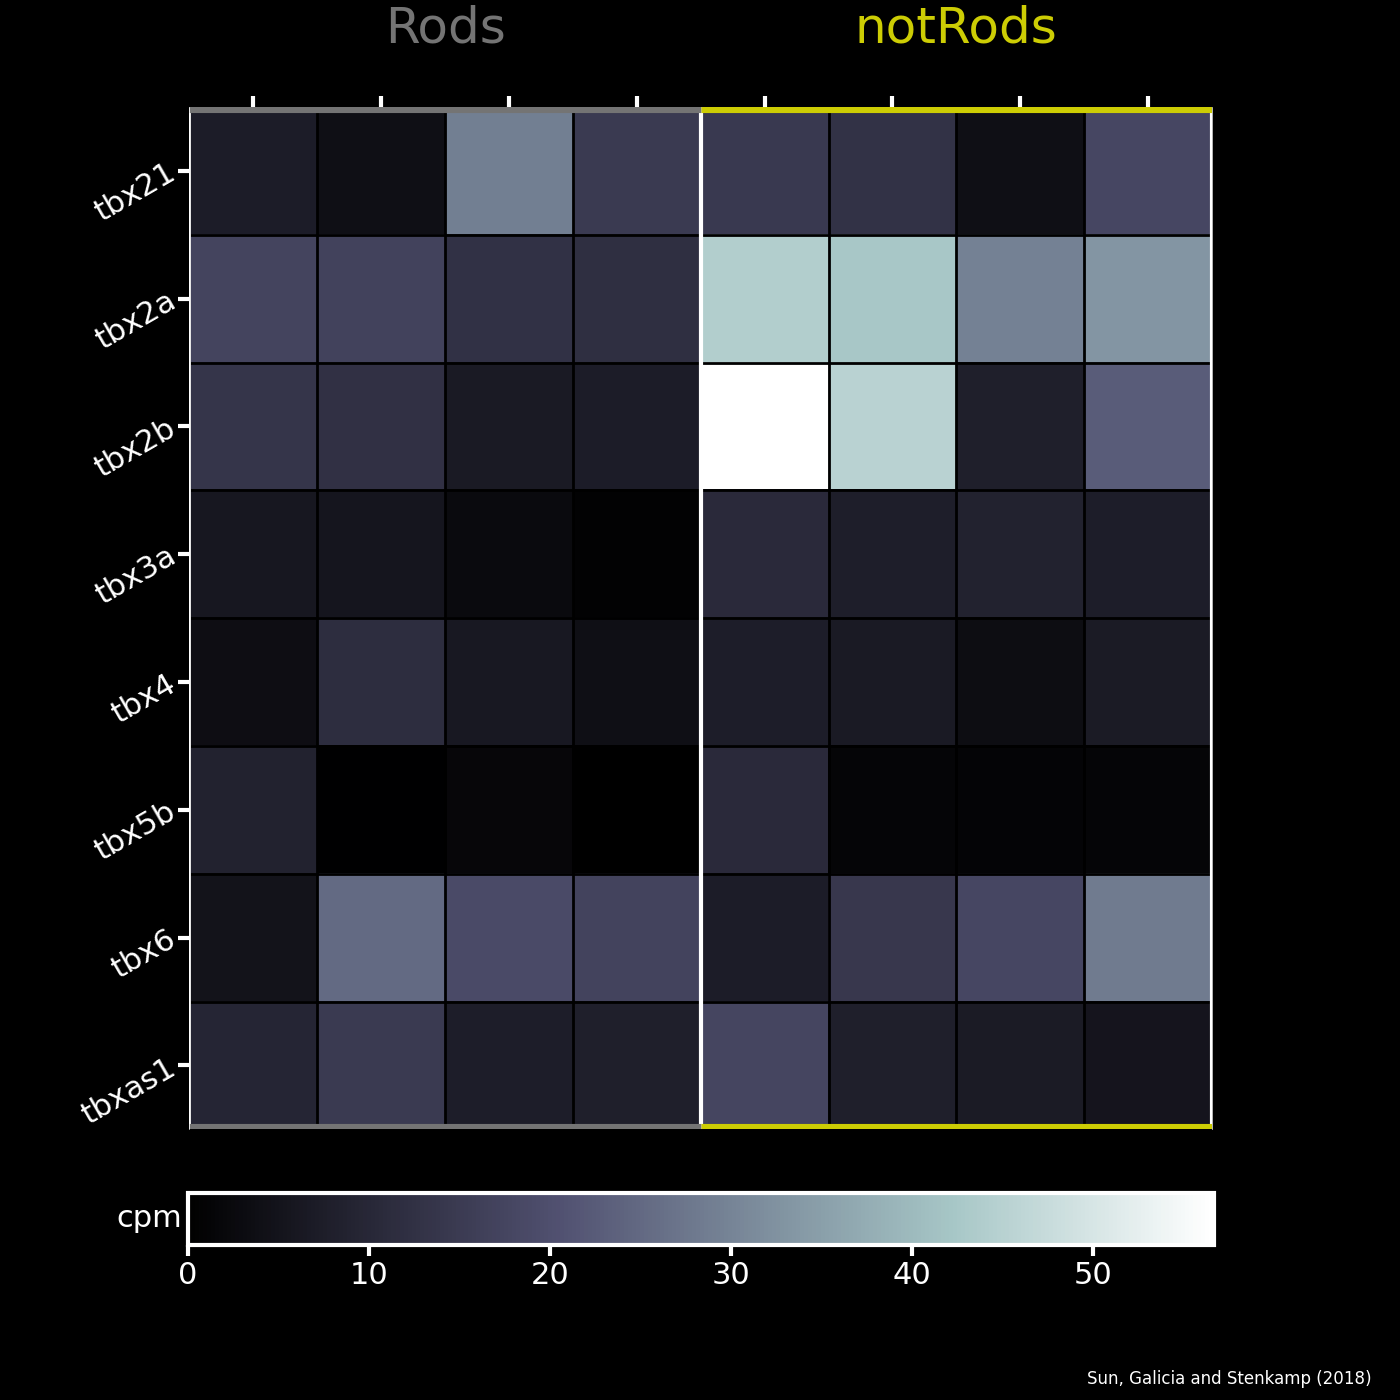

In [11]:
geneSymbol='tbx' # replace geneSymbol here and rerun cell to replot

heatmapData = gf[gf['symbol'].str.startswith(geneSymbol)]
heatmapData = heatmapData.sort_values(by=["symbol"])
heatmapDataO = zfO[zfO['symbol'].str.startswith(geneSymbol)]
heatmapDataO = heatmapDataO.sort_values(by=["symbol"])
heatmapDataH = zfH[zfH['symbol'].str.startswith(geneSymbol)]
heatmapDataH = heatmapDataH.sort_values(by=["symbol"])
heatmapDataS = zfS[zfS['symbol'].str.startswith(geneSymbol)]
heatmapDataS = heatmapDataS.sort_values(by=["symbol"])


fH, axH = plt.subplots(figsize=(20,(heatmapDataO.shape[0])+4))
hm, cb = heatmap(heatmapData, pC=pC, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Angueyra et al. (2022)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHO = plt.subplots(figsize=(16,(heatmapDataO.shape[0])+6))
hmO, cbO = heatmap_Ogawa2021(heatmapDataO, pC=pC, pctPlot=False, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Ogawa and Corbo (2021)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHH = plt.subplots(figsize=(14,(heatmapDataH.shape[0])+6))
hmH, cbH = heatmap_Hoang2020(heatmapDataH, pC=pC, pctPlot=False, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Hoang et al. (2020)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHS = plt.subplots(figsize=(14,(heatmapDataS.shape[0])+6))
hmS, cbS = heatmap_Sun2018(heatmapDataS, pC=pC, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Sun, Galicia and Stenkamp (2018)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()


***
## HeatMap for gene list across studies: provide gene symbol separated by "|" (e.g. '_tbx2a_|_tbx2b_|_foxq2_')<a id='heatMapList_otherStudies'></a>
> retrieves all genes in list and creates heatmap  
***

[Back to Index](#Index)

In [12]:
# display option for normalization
heatmapNorm

Checkbox(value=False, description='Heatmap normalization')

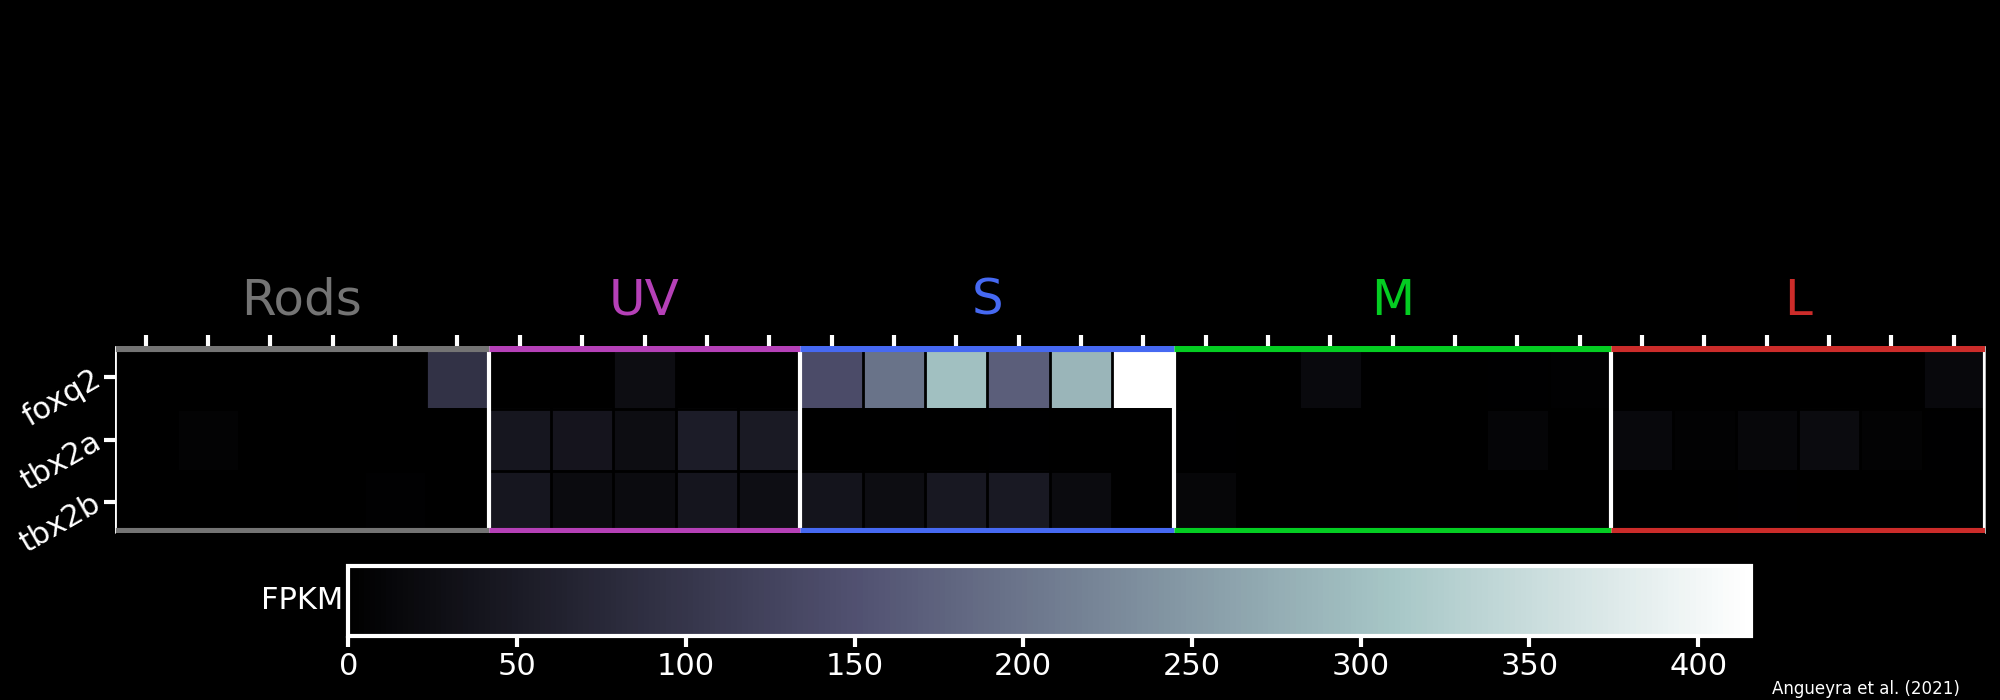

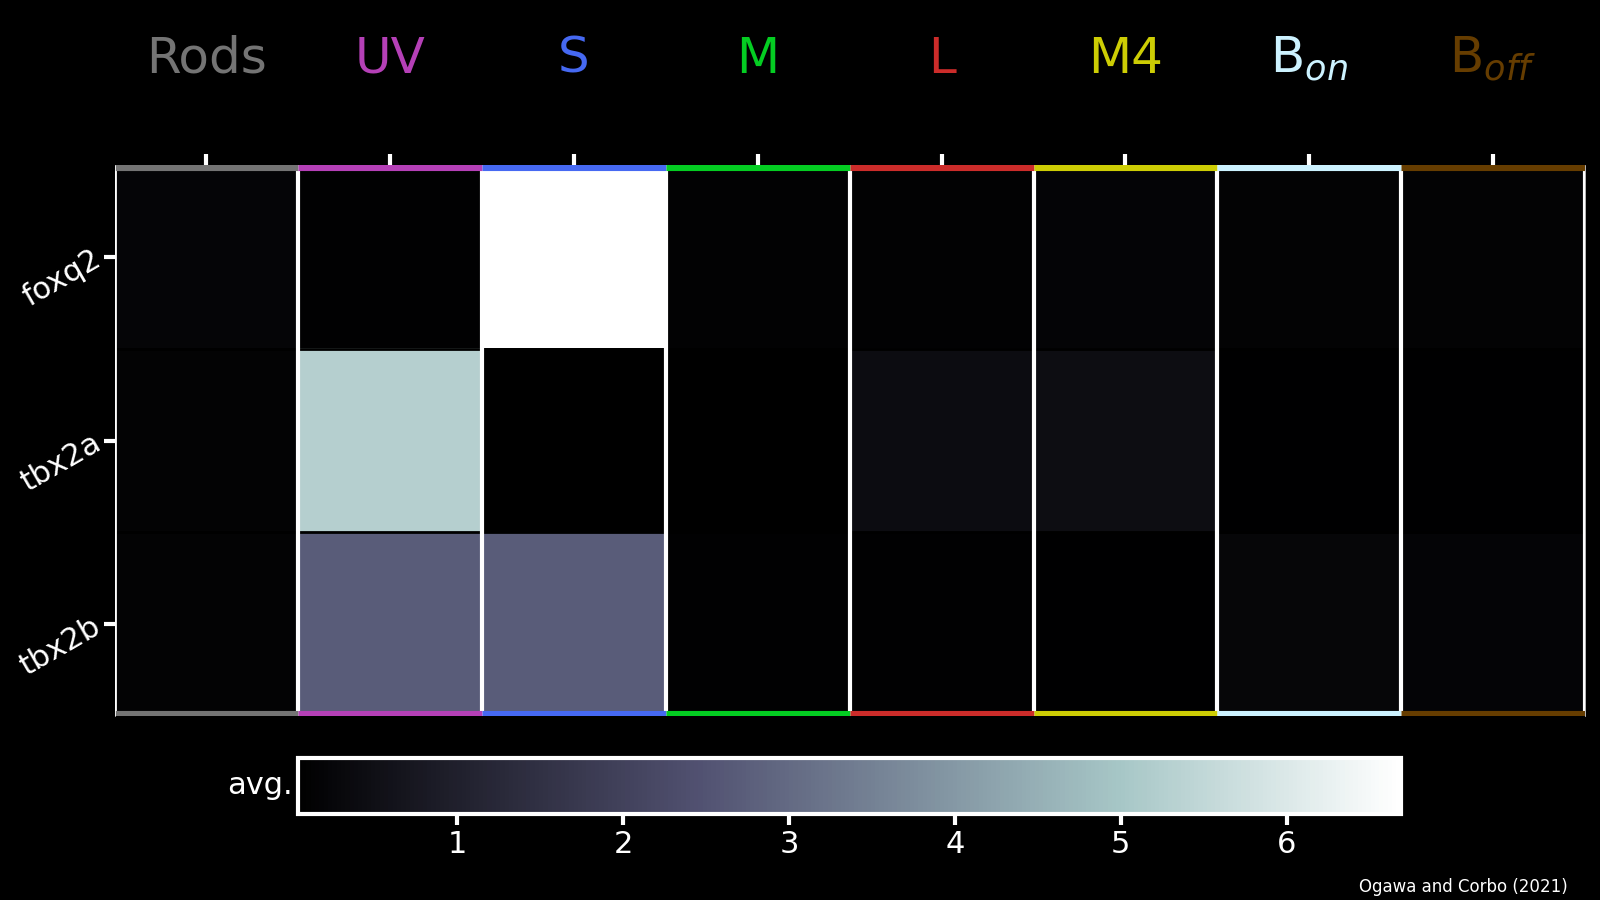

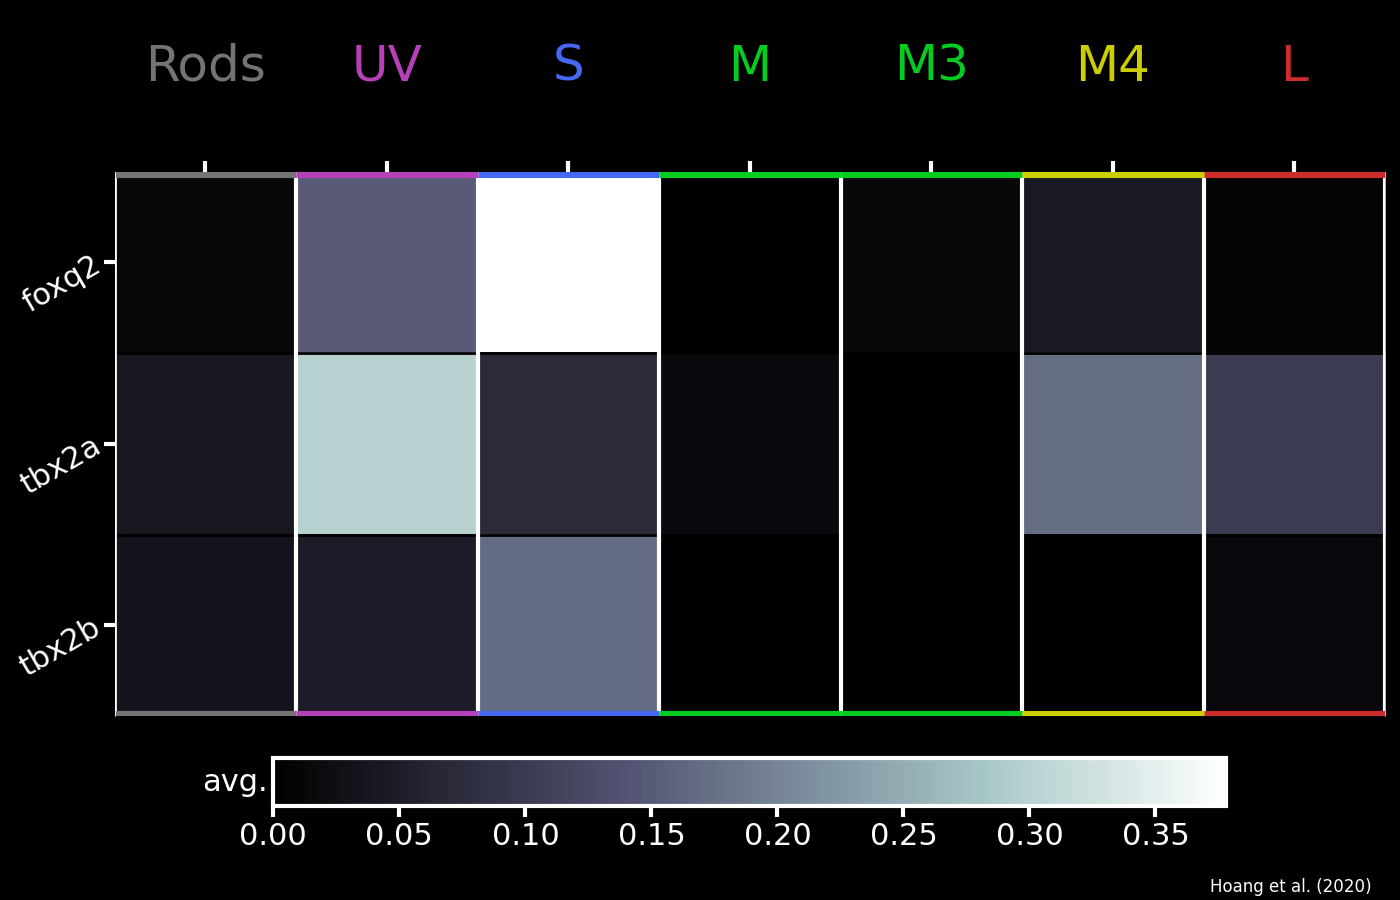

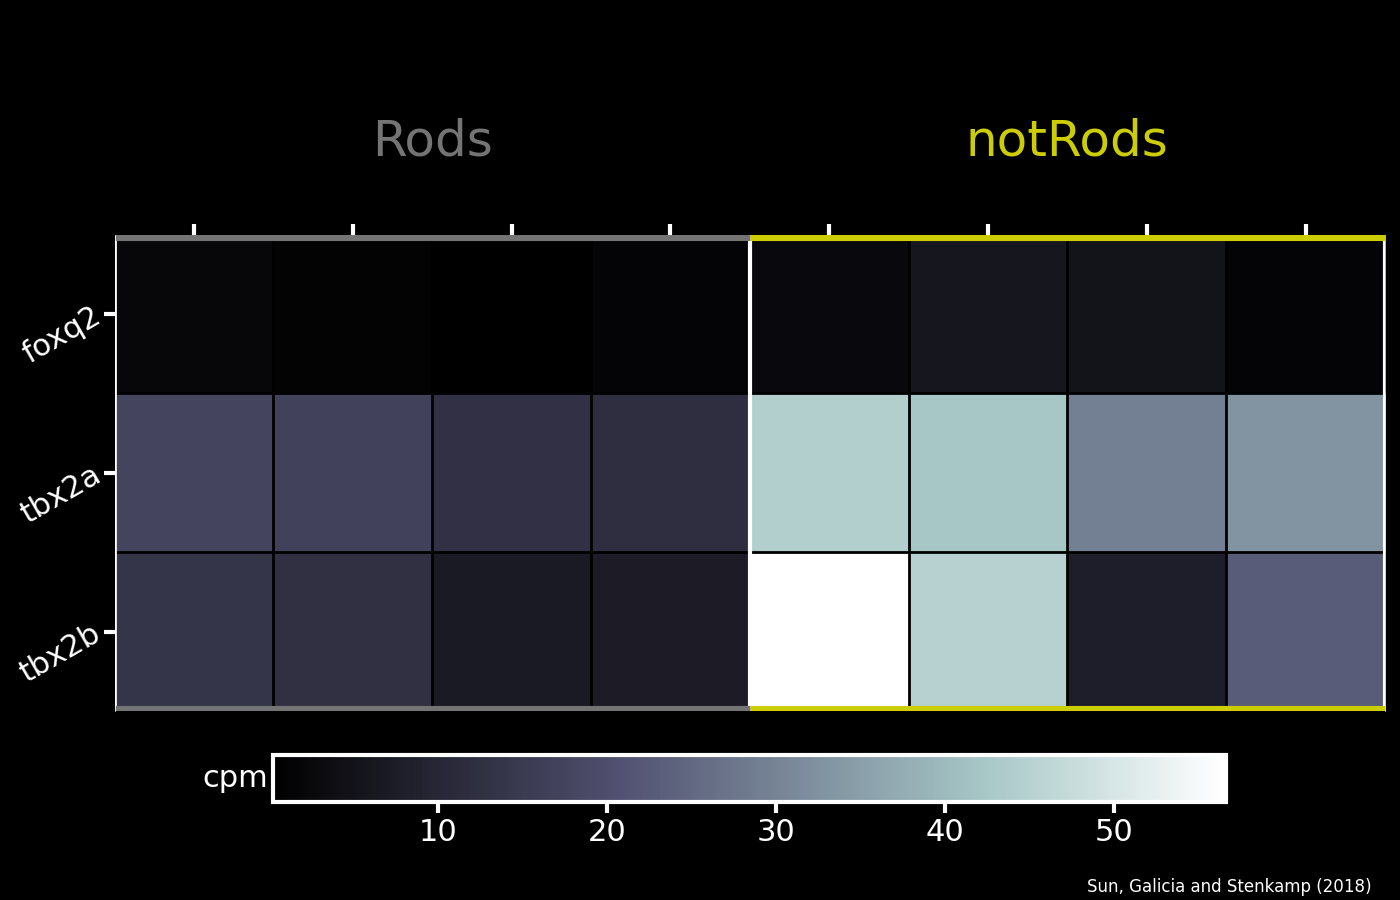

In [13]:
geneSymbol='tbx2a|tbx2b|foxq2' # replace geneSymbol here and rerun cell to replot

heatmapData = gf[gf['symbol'].str.contains(geneSymbol)]
heatmapData = heatmapData.sort_values(by=["symbol"])
heatmapDataO = zfO[zfO['symbol'].str.contains(geneSymbol)]
heatmapDataO = heatmapDataO.sort_values(by=["symbol"])
heatmapDataH = zfH[zfH['symbol'].str.contains(geneSymbol)]
heatmapDataH = heatmapDataH.sort_values(by=["symbol"])
heatmapDataS = zfS[zfS['symbol'].str.contains(geneSymbol)]
heatmapDataS = heatmapDataS.sort_values(by=["symbol"])

fH, axH = plt.subplots(figsize=(20,(heatmapDataO.shape[0])+4))
hm, cb = heatmap(heatmapData, pC=pC, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Angueyra et al. (2022)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHO = plt.subplots(figsize=(16,(heatmapDataO.shape[0])+6))
hmO, cbO = heatmap_Ogawa2021(heatmapDataO, pC=pC, pctPlot=False, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Ogawa and Corbo (2021)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHH = plt.subplots(figsize=(14,(heatmapDataH.shape[0])+6))
hmH, cbH = heatmap_Hoang2020(heatmapDataH, pC=pC, pctPlot=False, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Hoang et al. (2020)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()
fH, axHS = plt.subplots(figsize=(14,(heatmapDataS.shape[0])+6))
hmS, cbS = heatmap_Sun2018(heatmapDataS, pC=pC, norm=heatmapNorm.value)
plt.figtext(0.98,0.015,"Sun, Galicia and Stenkamp (2018)", va="center", ha="right", rotation= 0, size=12)
plt.tight_layout()
plt.show()